Manav Garg - IHX Recruitment Task 1

**Problem:**
1. Take the open-source dataset: https://huggingface.co/datasets/imdb 
2. Load any model from huggingface and its tokenizer. Load another tokenizer from spacy for 
reference. 
3. Tokenize the dataset using the two tokenizers and save the tokens from the two tokenizers 
separately in two lists. 
4. Now, take top 1000 tokens based on the information value/entropy*1 of the tokens, from 
the two lists. Now you have two lists, each of 1000 tokens. 
5. Compare the two list of tokens (it is up to you how you want to compare, create plots, 
generate some metrics etc.).*2 Based on the comparison which one do you think creates 
better tokens – does the result match your intuition? Which one would you use for a 
sentiment classification task? Why?

**Thought process:**
1. Firstly, To visulize, analyse the dataset and pre process the text in order to tokenize it. 
    To do this, firstly we import required libraries and then using those libraries we first pre process the text by removing urls, stop words, punctuations etc in order to prepare the sentences for tokenization.

2. Secondly, Deciding on which huggingface tokenizer to choose in order to accomodate the whole dataset.  
    The choice was to choose, BERT (uncased) model

3. Now due to the dataset being a relatively larger dataset with longer sequences, if we go ahead with standalone (1 process) for computation it may take relatively longer than usual. In order to solve this issue, we can implement/use ProcessPoolExecutor, to create sub-workers that can work parallely to tokenize the sentences.

4. After tokenization, we can calculate the entropy of both the tokenizers, spaCy tokenizer and huggingface tokenizer "BERT"
    For calculating entropy (uncertainty) we can use shannon's entropy formula.
     
5. After calculating entropy of both the token lists, we can plot the avg token lengths, get insights about the tokens, also see whether there was sub-token generation or not. BERT and many other transformer models from huggingface have sub-token generation, we can enhance the efficieny of the models using these tokens for text classification in scenarios such as the current one as well as social media texts, where language may sometimes be informal.

6. Finally, creating a comparison table

# 1. Importing Libraries

In [45]:
!pip install contractions

In [14]:
import datasets # used to load the dataset
from transformers import BertTokenizerFast # for using BERT tokenizer
import spacy # tokenizer library
import math # math lib
from collections import Counter # easy to use counter lib to count no of times an element is present in the list
from concurrent.futures import ProcessPoolExecutor # for parallel computing
import string
import contractions # for the removal of contractions
import re
import time

# 2. Loading the IMDB dataset

In [3]:
ds = datasets.load_dataset("stanfordnlp/imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

## 2.1 Split the dataset into train and test

In [5]:
train_dataset = ds["train"]

In [6]:
train_dataset["text"][:5]

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

# 3. Load the tokenizers

In [7]:
huggingface_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased',clean_up_tokenization_spaces=True)

spacy_tokenizer = spacy.blank("en")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# 4. Text Preprocessing
    1. Lowering case of sentences
    2. Removal of URLs
    3. Removal of Contractions
    4. Removal of Punctuations
    5. Removal of Numbers
    6. Removal of Extra Spaces
    7. Removal of stop words

In [8]:
stop_words = spacy_tokenizer.Defaults.stop_words

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = contractions.fix(text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    return " ".join(tokens)

# Parallel text cleaning and tokenization.
# Utilize multi threaded process to clean the texts on multiple threads or "processes" for faster and parallel computation
def clean_parallelly(texts, num_workers=128):
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        cleaned_sentences = list(executor.map(clean_text, texts))
    return cleaned_sentences

In [9]:
# Clean and tokenize the train dataset in parallel
cleaned_text = clean_parallelly(train_dataset["text"])

In [10]:
cleaned_text[:5]

['rented curiousyellow video store controversy surrounded released heard seized yous customs tried enter country fan films considered controversial myselfbr br plot centered young swedish drama student named lena wants learn life particular wants focus attentions making sort documentary average swede thought certain political issues vietnam war race issues united states asking politicians ordinary denizens stockholm opinions politics sex drama teacher classmates married menbr br kills curiousyellow years ago considered pornographic sex nudity scenes far shot like cheaply porno countrymen mind find shocking reality sex nudity major staple swedish cinema ingmar bergman arguably answer good old boy john ford sex scenes filmsbr br commend filmmakers fact sex shown film shown artistic purposes shock people money shown pornographic theaters america curiousyellow good film wanting study meat potatoes pun intended swedish cinema film plot',
 'curious yellow risible pretentious steaming pile ma

# 5. Tokenization

## 5.1 Function Definitions

In [11]:
# Function to merge sub-tokens
def merge_subtokens(tokens):
    merged_tokens = []
    current_word = ""

    for token in tokens:
        if token.startswith("##"):
            current_word += token[2:]
        else:
            if current_word:
                merged_tokens.append(current_word)
            current_word = token
    
    # Append the last word
    if current_word:
        merged_tokens.append(current_word)

    return merged_tokens

In [64]:
# Tokenization functions
def tokenize_huggingface(text):
    return huggingface_tokenizer.tokenize(text)

def tokenize_spacy(text):
    return [token.text.lower() for token in spacy_tokenizer(text)]

In [13]:
# Utilize multi threaded process to tokenize the texts on multiple threads or "processes" for faster and parallel computation
def parallel_tokenize(texts, tokenize_function, num_workers=128, merge=True):
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        tokens = list(executor.map(tokenize_function, texts))
    if merge == True:
        return merge_subtokens([token for sublist in tokens for token in sublist])
    else:
        return [token for sublist in tokens for token in sublist]

## 5.2 Performing tokenization

In [ ]:
# Perform tokenization in parallel way
time_st = time.time()
huggingface_tokens_STmerged = parallel_tokenize(cleaned_text, tokenize_huggingface)
time_ed = time.time()
time_bert_STmerged = time_ed - time_st

In [16]:
huggingface_tokens_STmerged[:5]

['rented', 'curiousyellow', 'video', 'store', 'controversy']

In [ ]:
time_st = time.time()
huggingface_tokens = parallel_tokenize(cleaned_text, tokenize_huggingface, merge=False)
time_ed = time.time()
time_bert = time_ed - time_st

In [18]:
huggingface_tokens[:5]

['rented', 'curious', '##ye', '##llo', '##w']

In [65]:
time_st = time.time()
spacy_tokens = parallel_tokenize(cleaned_text, tokenize_spacy)
time_ed = time.time()
time_spacy = time_ed - time_st

In [20]:
spacy_tokens[:5]

['rented', 'curiousyellow', 'video', 'store', 'controversy']

## 5.3 Calculating Entropy using Shannon's Entropy formula

In [21]:
import numpy as np

**$H(X) = -\sum_{i=1}^{n} p(x_i) \log_b p(x_i)$**

In [22]:
# Shannon Entropy
def calculate_entropy(frequencies):
    total = sum(frequencies.values())
    probs = np.array(list(frequencies.values())) / total
    # normalizing
    probs = probs / np.sum(probs)
    log_prob = np.log(probs) / np.log(2)
    # Calculate the entropy
    entropy = -np.sum(probs * log_prob)
    return entropy

# Get top N tokens by entropy
def get_top_tokens(tokens):
    frequencies = Counter(tokens)
    # Calculating entropy for the entire distribution
    tokens_entropy = calculate_entropy(frequencies)
    
    # Sort tokens by frequency and select the top 1000
    top_tokens = [token for token, _ in frequencies.most_common(1000)]
    
    return top_tokens, tokens_entropy

In [23]:
# Get the top tokens for both tokenizers
huggingface_top_tokens, huggingface_token_entropy = get_top_tokens([token for token in huggingface_tokens])

In [24]:
huggingface_token_entropy

12.126926224402107

In [25]:
huggingface_top_tokens[:5]

['br', 'movie', '##s', '##br', 'film']

In [26]:
huggingface_top_tokens_STmerged, huggingface_token_entropy_STmerged = get_top_tokens([token for token in huggingface_tokens_STmerged])

In [27]:
huggingface_token_entropy_STmerged

12.678656657938854

In [28]:
huggingface_top_tokens_STmerged[:5]

['br', 'movie', 'film', 'like', 'good']

In [29]:
spacy_top_tokens, spacy_token_entropy = get_top_tokens([token for token in spacy_tokens])

In [68]:
spacy_token_entropy

12.680629690494133

In [31]:
spacy_top_tokens[:5]

['br', 'movie', 'film', 'like', 'good']

# 6. Compare the three lists of tokens

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

## 6.1 Calculate overlap

In [33]:
overlap = set(huggingface_top_tokens) & set(spacy_top_tokens)
overlap_percentage = len(overlap) / 1000 * 100

print(f"Overlap between huggingface tokenizer(BERT) (w/ Subtokens) and spaCy tokens: {overlap_percentage:.2f}%")

overlap_STmerged = set(huggingface_top_tokens_STmerged) & set(spacy_top_tokens)
overlap_percentage_STmerged = len(overlap) / 1000 * 100

print(f"Overlap between huggingface tokenizer(BERT) (w/o Subtokens) and spaCy tokens: {overlap_percentage:.2f}%")

Overlap between huggingface tokenizer(BERT) (w/ Subtokens) and spaCy tokens: 77.80%
Overlap between huggingface tokenizer(BERT) (w/o Subtokens) and spaCy tokens: 77.80%


## 6.2 Plot token length distribution

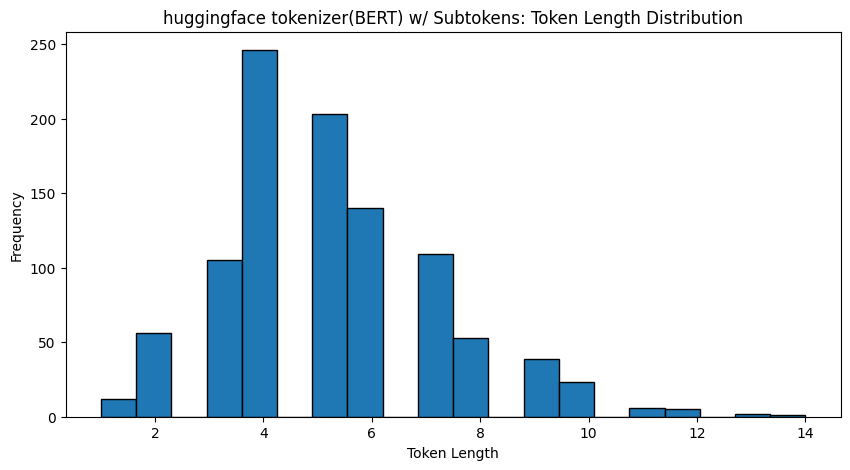

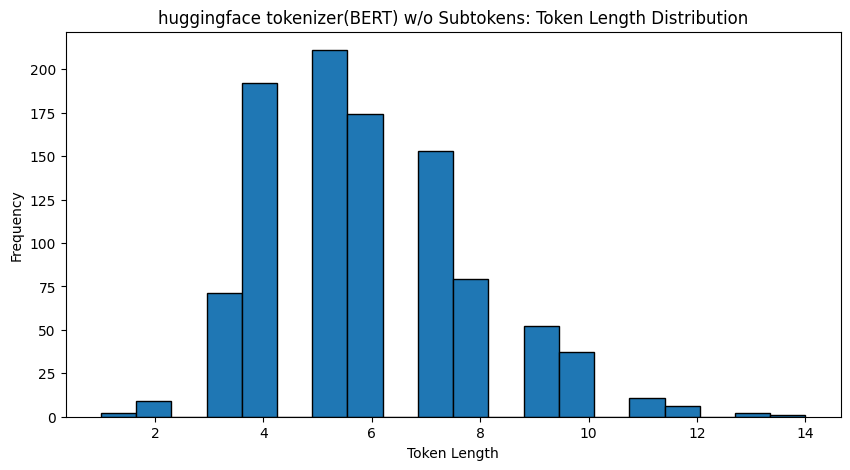

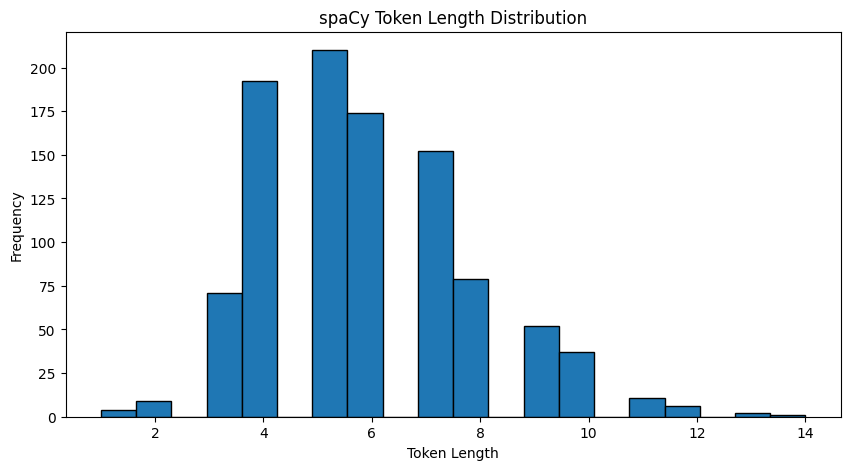

In [34]:
def plot_tokenLength_dist(tokens, title):
    lengths = [len(token) for token in tokens]
    plt.figure(figsize=(10, 5))
    plt.hist(lengths, bins=20, edgecolor='black')
    plt.title(title)
    plt.xlabel("Token Length")
    plt.ylabel("Frequency")
    plt.show()

plot_tokenLength_dist(huggingface_top_tokens, "huggingface tokenizer(BERT) w/ Subtokens: Token Length Distribution")
plot_tokenLength_dist(huggingface_top_tokens_STmerged, "huggingface tokenizer(BERT) w/o Subtokens: Token Length Distribution")
plot_tokenLength_dist(spacy_top_tokens, "spaCy Token Length Distribution")

## 6.3 Calculate average token length

In [35]:
huggingface_avg_length = np.mean([len(token) for token in huggingface_top_tokens])
huggingface_avg_length_STmerged = np.mean([len(token) for token in huggingface_top_tokens_STmerged])
spacy_avg_length = np.mean([len(token) for token in spacy_top_tokens])

print(f"Average huggingface tokenizer(BERT) w/o subtokens: token length: {huggingface_avg_length_STmerged:.2f}")
print(f"Average huggingface tokenizer(BERT) w/ subtokens: token length: {huggingface_avg_length:.2f}")
print(f"Average spaCy token length: {spacy_avg_length:.2f}")

Average huggingface tokenizer(BERT) w/o subtokens: token length: 5.87
Average huggingface tokenizer(BERT) w/ subtokens: token length: 5.21
Average spaCy token length: 5.86


## 6.4 Compare unique tokens

In [38]:
huggingface_unique = set(huggingface_top_tokens) - set(spacy_top_tokens)
huggingface_unique_STmerged = set(huggingface_top_tokens_STmerged) - set(spacy_top_tokens)
spacy_unique = set(spacy_top_tokens) - set(huggingface_top_tokens)
spacy_unique_BERTst = set(spacy_top_tokens) - set(huggingface_top_tokens_STmerged)

print("Sample of unique huggingface tokenizer(BERT) w/ subtokens (in comparison with spaCy):", list(huggingface_unique)[:10])
print("Sample of unique spaCy tokens (in comparison with BERT w/ subtokens):", list(spacy_unique)[:10])
print("------------------------------")
print("Sample of unique huggingface tokenizer(BERT) w/o subtokens (in comparison with spaCy):", list(huggingface_unique_STmerged)[:10])
print("Sample of unique spaCy tokens (in comparison with BERT w/o subtokens):", list(spacy_unique_BERTst)[:10])

Sample of unique huggingface tokenizer(BERT) w/ subtokens (in comparison with spaCy): ['##ism', '##oo', '##ed', 'sl', 'gr', '##est', '##ist', '##in', '##her', '##ers']
Sample of unique spaCy tokens (in comparison with BERT w/ subtokens): ['army', 'decides', 'honest', 'tony', 'violent', 'follows', 'barely', 'starring', 'glad', 'ended']
------------------------------
Sample of unique huggingface tokenizer(BERT) w/o subtokens (in comparison with spaCy): ['purpose', 'naked']
Sample of unique spaCy tokens (in comparison with BERT w/o subtokens): ['d', '\x96']


## 6.5 Calculate subword token percentage (for huggingface tokenizer(BERT))

In [37]:
huggingface_subword_percentage = len([t for t in huggingface_top_tokens if t.startswith("##")]) / 1000 * 100
print(f"Percentage of subword tokens in huggingface tokenizer(BERT): {huggingface_subword_percentage:.2f}%")

Percentage of subword tokens in huggingface tokenizer(BERT): 13.70%


## 6.6 Create a comparison DataFrame

In [67]:
# 6.6 Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['Overlap', 'Entropy','Avg Token Length', 'Subword Tokens', 'Tokenization Time','Unique Tokens'],
    'BERT w/ Subtokens': [overlap_percentage, f"{huggingface_token_entropy:.3f}", huggingface_avg_length, huggingface_subword_percentage, f"{time_bert:.2f}s", len(huggingface_unique)],
    'BERT w/o Subtokens': [overlap_percentage_STmerged, f"{huggingface_token_entropy_STmerged:.3f}", huggingface_avg_length_STmerged, 0, f"{time_bert_STmerged:.2f}s", len(huggingface_unique_STmerged)],
    'spaCy': [overlap_percentage, f"{spacy_token_entropy:.3f}", spacy_avg_length, 0, f"{time_spacy:.2f}s", 0]
})

print("\nComparison Summary:")
print(comparison_df)


Comparison Summary:
              Metric BERT w/ Subtokens BERT w/o Subtokens   spaCy
0            Overlap              77.8               77.8    77.8
1            Entropy            12.127             12.679  12.681
2   Avg Token Length             5.212              5.874   5.864
3     Subword Tokens              13.7                  0       0
4  Tokenization Time            29.84s             30.17s  46.95s
5      Unique Tokens               222                  2       0
